**ACHTUNG!** Before you do anything else, change `uni` in the name of this file to, well, your UNI. (Right-click the title and select 'Rename Notebook'.)

# Geomapping and Stokes' Theorem

This lab is a quick(ish) exercise in applying the concepts of parameterized curves and surfaces to some geographic regions on Earth. It should be clear this is not a rigorous treatment or ready for real-world deployment. 

We'll start with some standard mathy modules.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from numpy import sin,cos,arccos,pi,array,arange,linspace,meshgrid

from ipywidgets import interact

There are many different, widely-used systems for storing geographic data: KML, GeoJSON, GPS exchange format, just to name a few. We'll use a fairly simple but common one called Shapefiles (`.shp`). 

This next block should install a python module that can read them. 

In [5]:
try:
    import shapefile as shp
except:
    import sys
    !{sys.executable} -m pip install --user pyshp
    import shapefile as shp

You can find shape files all over the internet for most any municipality or geographic feature you are interested in. Here are some from the [Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). Here are the [arrondissements of Paris](https://www.data.gouv.fr/en/datasets/arrondissements-1/).

I have included in this folder files for the states of the USA and (many) countries of the world. 

In [7]:
us_states = shp.Reader("./cb_2018_us_state_500k.shp")
countries = shp.Reader("./ne_50m_admin_0_countries.shp")

A good way to explore these files, which can contain a host of information, and not all with the same structure, is to import them into a pandas dataframe. If you're not familiar with such a thing, it is basically a big spreadsheet table in python. 

In [8]:
def shp2df(sf):
    """This function reads a shapefile object imported by shapefile.Reader into a Pandas dataframe."""
    df = pd.DataFrame(columns=[x[0] for x in sf.fields][1:],data=sf.records())
    df["PARTS"] = [s.parts for s in sf.shapes()]
    df["COORDS"] = [s.points for s in sf.shapes()]
    return df

In [9]:
us = shp2df(us_states)
us.sample(4)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,PARTS,COORDS
14,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,[0],"[(-104.057879, 44.997605), (-104.050783, 44.99..."
24,56,01779807,0400000US56,56,WY,Wyoming,00,251458544898,1867670745,[0],"[(-111.054556, 45.000955), (-111.045066048714,..."
51,38,01779797,0400000US38,38,ND,North Dakota,00,178707534813,4403267548,[0],"[(-104.048678345135, 48.863784991148094), (-10..."
42,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"[0, 665, 1102, 1206, 1313, 1583, 1591, 1600, 2...","[(-156.060759, 19.730549), (-156.0566630000000..."


In [10]:
# pandas is useful for making queries of your data
us[us.STUSPS == "HI"]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,PARTS,COORDS
42,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"[0, 665, 1102, 1206, 1313, 1583, 1591, 1600, 2...","[(-156.060759, 19.730549), (-156.0566630000000..."


## Latitude and longitude

Latitude and longitude are standard coordinates on the surface of the earth. One can write [books](https://www.indiebound.org/book/9780802715296) about them, but the short version is each is a scalar representing:
  - longitude: degrees east from the Greenwich meridean (negative is west)
  - latitude: degrees north of the equator (negative is south)

### Exercise 1

Write a function that converts a longitude-latitude pair (note the order) and converts them to the typical (for this class) spherical coordinates $(\theta,\phi)$.

In [ ]:
def longlat2thetaphi(longlat):
    """Convert (long,lat) pair to (theta,phi) pair."""
    lo, la = longlat # stores coordinates individually
    deg = pi/180 # might be useful
    theta = # your code here
    phi = # your code here
    return (theta, phi)

## Visualizing

The heart of the Shapefile is the list of coordinates for each entity. These are simply longitude-latitude pairs. We can plot them in the usual way via matplotlib. 

Let's try Utah. Note its index 22 (the first column above).

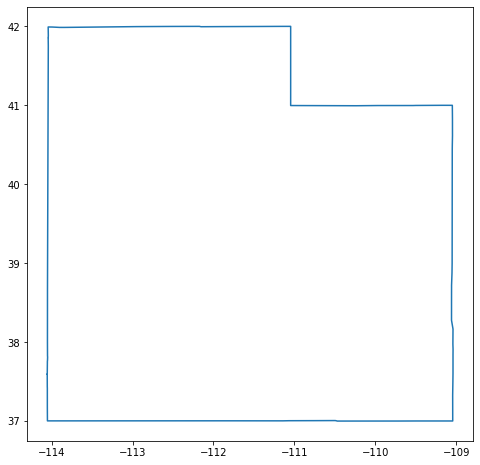

In [11]:
# use the index for Utah found above. 
coords = us.loc[22,"COORDS"]
x,y = np.column_stack(coords)

ratio = (np.max(y) - np.min(y)) / (np.max(x) - np.min(x))
plt.figure(figsize=(8,8*ratio))

plt.plot(x,y);

OK, let's try something with a few more features

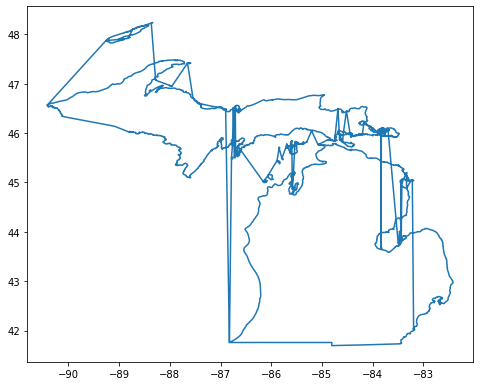

In [12]:
idx = us[us.NAME == "Michigan"].index[0]

coords = us.loc[idx,"COORDS"]
x,y = np.column_stack(coords)

# Set up figure
ratio = (np.max(y) - np.min(y)) / (np.max(x) - np.min(x))
plt.figure(figsize=(8,8*ratio))

plt.plot(x,y);

Not a mitten. You see we have a problem of topology. Michigan in not one connected land mass. This is where the PARTS column comes in. It indicates the boundaries that separated the list of coordinates into contiguous shapes ("rings"). 

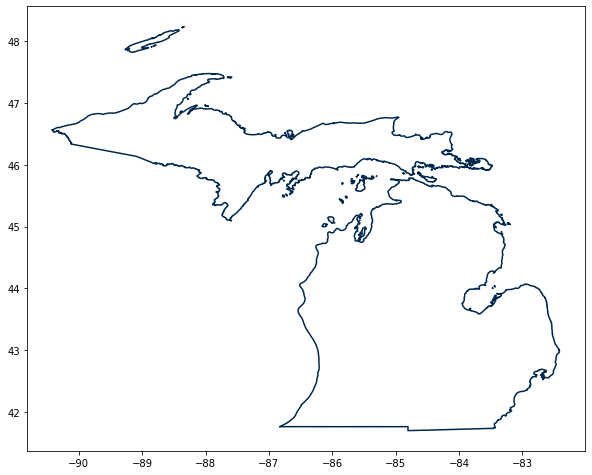

In [24]:
idx = us[us.NAME == "Michigan"].index[0]

col = (0,39/255,76/255) # Michigan blue

coords = us.loc[idx,"COORDS"]
parts = us.loc[idx,"PARTS"]
x,y = np.column_stack(coords)

ratio = (np.max(y) - np.min(y)) / (np.max(x) - np.min(x))
plt.figure(figsize=(10,10*ratio))

for i in range(len(parts) - 1):
    plt.plot(x[parts[i]:parts[i+1]],y[parts[i]:parts[i+1]],color=col);
plt.plot(x[parts[-1]:],y[parts[-1]:],color=col);

Better, but something is off. It is not just the missing maize. Michigan is looking a bit squished. That is because a degree of longitude is not generally equal to a degree of latitude. It depends where you are. 

As you likely know, mapping a curved surface like a sphere to a 2D plane accurately is not only difficult but [impossible](https://en.wikipedia.org/wiki/Gauss%E2%80%93Bonnet_theorem) to do perfectly accurately. Cartography is thus an art of doing the best one can for a particular application. 

### Exercise 2

Convert degrees longitude and latitude to km east and north, respectively, from Ann Arbor (42.2808° N, 83.7430° W). 

Make a plot in these new coordinates (color/labels not necessary). ![Michigan as measured in km from Ann Arbor](MI_in_color.png)

In [14]:
# Radius of Earth. You'll need this
R = 6378.1

In [ ]:
def longlat2km(longlat,center):
    lo, la = longlat
    a,b = center
    x = # put code here
    y = # put code here
    return (x,y)

# When complete, you could plot your conversion with the following code.
x,y = np.column_stack([longlat2km(ll) for ll in coords])

ratio = (np.max(y) - np.min(y)) / (np.max(x) - np.min(x))
plt.figure(figsize=(8,8*ratio))

for i in range(len(parts) - 1):
    plt.plot(x[parts[i]:parts[i+1]],y[parts[i]:parts[i+1]],color='k');
plt.plot(x[parts[-1]:],y[parts[-1]:],color='k');

### Exercise 3

Write a function that uses Green's theorem to estimate the surface area of a state. Recall,

$$ \text{Area}(D) = \oint_{\partial D} x\,dy $$

Hints:
  - First compute the line integral above for a general line segment between points $(x_1,y_1)$ and $(x_2,y_2)$.
  - If `arr` is a python iterable (array, list, etc.), you can sum its first `n` entries with `sum(arr[0:n])`

or if you need a more complex summand:

```
total = 0
for i in range(n):
    total += # something based on i
``` 

and the sum will be stored in `total`.

**Example** To sum the first 99 squares $$\sum_{i=0}^{99} i^2 $$ we write:

In [22]:
total = 0
for i in range(100):
    total += i**2

total # return it

328350

Alernatively,

In [23]:
sum([i**2 for i in range(100)])

328350

  - Third, and important. Shapefiles are oriented in a **clockwise** (!) direction. You'll need a negative sign.

In [ ]:
# You might define more definitions here. 

def land_area(statename):
    """Returns the approximate land area in km^2 of statename."""
    idx = us[us.NAME == statename].index[0]
    coords = us.loc[idx,"COORDS"]
    parts = us.loc[idx,"PARTS"]
    
    center = # write code to choose a "central" point to measure from. 
    
    # do the magic
    
    return total_area

# Moving into 3D

The method above will work reasonably well for small areas like the Central Park Reservoir or Rhode Island, but won't fair so well for something like Texas, Alaska, or, heaven forbid, Brazil. 

For this we must visualize our boundaries in 3D.

### Exercise 4

Convert latitude/longitude to $(x,y,z)$ coordinates in km with center of the earth at the origin. You can use `longlat2thetaphi` above

In [18]:
def longlat2xyz(longlat):
    # put code here
    lo,la = longlat
    deg = np.pi/180

    return # Your code here.

## Making a globe. 

In [15]:
world = shp2df(countries)

Add rough centers for each country for perspective. What might be wrong with this approach?

In [19]:
def center_of_coords(coords):
    x,y = np.column_stack(coords)
    return np.array((np.mean(x),np.mean(y)))

world["CENTER"] = world.COORDS.apply(center_of_coords)

In [20]:
cts = world.NAME.to_list()
cts.sort

@interact
def _(name=cts):
    plt.figure(figsize=(14,14))
    ax = plt.gca(projection='3d')
    
    cx,cy = world.loc[world.NAME == name,"CENTER"].values[0]
    
    for idx in world.index:
        country = world.loc[idx]
         
        # prettify, can be omitted
        s = country.NAME
        np.random.seed(sum([ord(c) for c in s]))
        col = np.random.rand(3)

        if s == name:
            alpha = 1
            lw= 3
        else:
            alpha = .7
            lw= 1

        longdist = np.abs(country.CENTER[0] - cx)
        if longdist > 180:
            longdist = 360 - longdist
        if longdist > 95:
            alpha = 0.2
        # end prettify     
            
        coords = country.COORDS
        parts = country.PARTS

        x,y,z = np.column_stack([longlat2xyz(xx) for xx in coords])
        num_parts = len(parts)
        for i in range(num_parts-1):
            plt.plot(x[parts[i]:parts[i+1]],y[parts[i]:parts[i+1]],z[parts[i]:parts[i+1]],color=col,alpha=alpha,lw=lw)
        plt.plot(x[parts[-1]:],y[parts[-1]:],z[parts[-1]:],color=col,alpha=alpha,lw=lw)


    for c in 'xyz':
        getattr(ax,f"set_{c}lim")(-R,R)
    ax.view_init(np.max((cy,5)),cx)

interactive(children=(Dropdown(description='name', options=('Zimbabwe', 'Zambia', 'Yemen', 'Vietnam', 'Venezue…

## Areas on the Globe

### Exercise 5

Compute the curl of the following vector field. $R$ is a constant (the radius of the earth).

$$ \mathbf F(x,y,z) = \frac{ R^2 }{(x^2 + y^2)\sqrt{x^2 + y^2 + z^2}} \left( - zy \,\mathbf i + zx \,\mathbf j \right) $$

Why is this significant for finding the area of a region on a sphere of radius $R$?

### Exercise 6

Write code to estimate the area of a land mass from a series of points along its perimeter.

You will construct a line integral. Use the following ideas to integrate it. 

In [ ]:
def midptarc(pt1,pt2):
    """Given two points on a sphere, return the midpoint on the great circle connecting them. 
    pt1 and pt2 are triples in xyz coordinates"""
    

Hint: Draw 2 points on a circle; find the midpoint of the cord connecting them. Extend a radius through this point to the circle.

In [ ]:
def gcdist(pt1,pt2):
    """Given two points on a sphere, return the distance along the great circle connecting them. 
    pt1 and pt2 are triples in xyz coordinates"""

Hint: Recall the dot product can be used to measure angles in 3-space too.

To estimate $\oint_C \mathbf F \cdot d\mathbf r $ given a series of points $P_0, P_1, \dots,P_n$ along $C$ on a sphere, let $M_i$ be the midpoint on the great circle (arc) between $P_{i-1}$ and $P_i$. Let $\mathbf T_i$ be the unit tangent vector to the arc at this point and $\Delta s_i$ the length of this segment. Then

$$\oint_C \mathbf F \cdot d\mathbf r  = \oint_C \mathbf F \cdot \mathbf T ds \approx \sum_{i=1}^n \mathbf F(M_i)\cdot \mathbf T_i \Delta s_i $$

Hint: relate $\mathbf T_i$ to $\overrightarrow{P_{i-1}P_i}$.

In [ ]:
def land_area_3d(coords):
    # insert code here. 

### Exercise 7

Estimate the land area of Brazil.

### Challenge

Worth thinking about. Not necessary to complete for full credit. 

The vector field $\mathbf F$ above is undefined at the poles, so what do we do about Antarctica?

Show that no vector field works for area of all regions on the globe at once. That is, there is nothing we could replace $\mathbf F$ with that would work on all regions. (What would $\nabla \times \mathbf F$ have to be? Why can't any curl be that? Use Stokes' on the whole sphere.)

What is the area of Antarctica?